1). Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

brent_data = pd.read_csv('my_BRENT2019.csv', sep = ',', index_col=[0], parse_dates=[0], usecols=['Дата', 'Значение'])
brent_data.head()

,Значение
Дата,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63


In [2]:
d_brent_data = brent_data.copy().iloc[:-1]
d_brent_data['Значение'] = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]

In [3]:
d_brent_data.head()

,Значение
Дата,
2010-09-01,0.52
2010-09-02,-0.32
2010-09-03,0.05
2010-09-04,0.01
2010-09-05,0.24


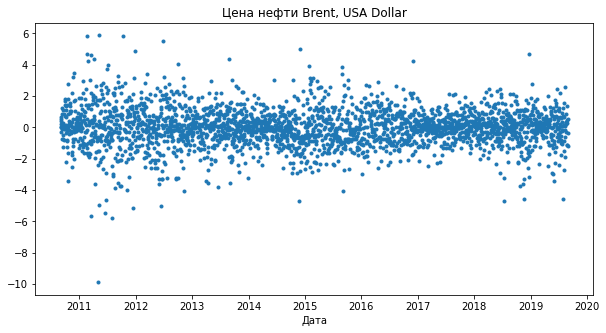

In [4]:
plt.figure(figsize=(10,5))
plt.plot(d_brent_data.index, d_brent_data['Значение'], '.')
plt.xlabel('Дата')
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

2). Добавьте первые разности по стоимости доллара и евро к рублю сделайте ее перрасчет (ресемплинг) в представление по неделям.

In [5]:
rub_doll=pd.read_excel('rub_usd.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [6]:
rub_eur=pd.read_excel('rub_eur.xlsx')
rub_eur.index = pd.to_datetime(rub_eur['data'].values).date
rub_eur.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_eur.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [7]:
d_rub_doll = rub_doll.copy().iloc[:-1]
d_rub_doll['curs'] = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
d_rub_doll.head()

,curs
2010-09-01,-0.0668
2010-09-02,-0.1143
2010-09-03,0.0064
2010-09-04,-0.1151
2010-09-07,0.1548


In [8]:
d_rub_eur = rub_eur.copy().iloc[:-1]
d_rub_eur['curs'] = rub_eur['curs'].values[1:]- rub_eur['curs'].values[:-1]
d_rub_eur.head()

,curs
2010-09-01,0.1527
2010-09-02,0.1247
2010-09-03,0.0604
2010-09-04,0.1215
2010-09-07,-0.1505


In [9]:
d_brent_data['d_rub_doll'] = d_rub_doll['curs']
d_brent_data['d_rub_doll'] = d_brent_data['d_rub_doll'].fillna(method='ffill')
d_brent_data['d_rub_eur'] = d_rub_eur['curs']
d_brent_data['d_rub_eur'] = d_brent_data['d_rub_eur'].fillna(method='ffill')
d_brent_data = d_brent_data.resample('W').mean()
d_brent_data = d_brent_data.fillna(method='ffill')

d_brent_data.head()

,Значение,d_rub_doll,d_rub_eur
Дата,,,
2010-09-05,0.100000,-0.080980,0.11616
2010-09-12,0.386667,-0.001517,-0.00450
2010-09-19,0.028333,0.041533,0.35245
2010-09-26,-0.203333,-0.004617,0.15585
2010-10-03,0.860000,-0.026800,0.06365


3). Постройте модель предсказания 1-й точки от текущей (h=1).

In [10]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Дата') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Дата') >  split_date].copy()

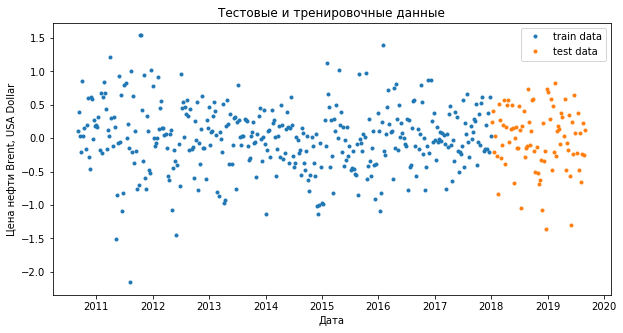

In [11]:
train, test = split_data(d_brent_data, '01-06-2018')

plt.figure( figsize=( 10, 5 ))
plt.xlabel('Дата')
plt.ylabel('Цена нефти Brent, USA Dollar')
plt.plot(train.index, train['Значение'], '.', label='train data' )
plt.plot(test.index, test['Значение'], '.', label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()


In [12]:
X_train = train.iloc[:-1,:]
y_train = train['Значение'].values[1:]
X_test = test.iloc[:-1,:]
y_test = test['Значение'].values[1:]
X_train.drop( columns = 'Значение', inplace = True )
X_test.drop( columns = 'Значение', inplace = True )

C:\Users\horne\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

model_g = GradientBoostingRegressor(max_depth=15, random_state=24, n_estimators=100)

In [14]:
model_g.fit( X_train, y_train )


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=24, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
X_test_pred_g = model_g.predict(X_test)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er_g_d = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_g)
er_g_d

329.6027959547683

4). Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Сначала соберем аналогичный датасет, но со стандартными значениями.

In [17]:
n_brent_data = brent_data.copy()
n_brent_data['rub_doll'] = rub_doll['curs']
n_brent_data['rub_doll'] = n_brent_data['rub_doll'].fillna(method='ffill')
n_brent_data['rub_eur'] = rub_eur['curs']
n_brent_data['rub_eur'] = n_brent_data['rub_eur'].fillna(method='ffill')
n_brent_data = n_brent_data.resample('W').mean()
n_brent_data = n_brent_data.fillna(method='ffill')

n_brent_data.head()

,Значение,rub_doll,rub_eur
Дата,,,
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.693333,30.844500,39.764250
2010-09-26,78.518333,31.012233,40.967983
2010-10-03,81.211667,30.607417,41.345817


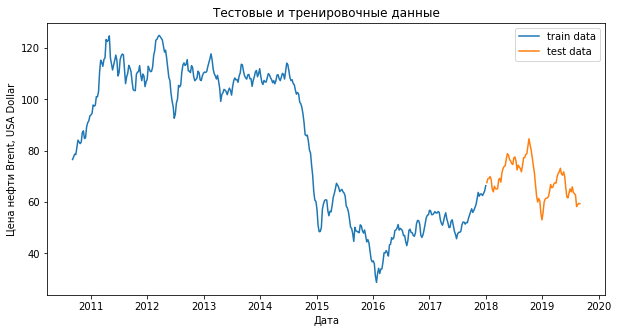

In [18]:
train, test = split_data(n_brent_data, '01-06-2018')

plt.figure( figsize=( 10, 5 ))
plt.xlabel('Дата')
plt.ylabel('Цена нефти Brent, USA Dollar')
plt.plot(train.index, train['Значение'], label='train data' )
plt.plot(test.index, test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [19]:
X_train = train.iloc[:-1,:]
y_train = train['Значение'].values[1:]
X_test = test.iloc[:-1,:]
y_test = test['Значение'].values[1:]
X_train.drop( columns = 'Значение', inplace = True )
X_test.drop( columns = 'Значение', inplace = True )

C:\Users\horne\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=24, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
X_test_pred_g = model_g.predict(X_test)

In [22]:
er_g_n = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_g)
er_g_n

25.237719742382247

In [24]:
print('ошибка модели первых разностей : {0}, ошибка модели стандартной : {1}'.format(er_g_d, er_g_n))

ошибка модели первых разностей : 329.6027959547683, ошибка модели стандартной : 25.237719742382247
